# Tutorial

.. contents::
    :local:

## define a dimarray

A **``DimArray``** can be defined just like a numpy array, with
additional information about its axes, which can be given
via `axes` and `dims` parameters.

In [1]:
from dimarray import DimArray, Dataset
a = DimArray([[1.,2,3], [4,5,6]], axes=[['a', 'b'], [1950, 1960, 1970]], dims=['variable', 'time'])
a

dimarray: 6 non-null elements (0 null)
0 / variable (2): 'a' to 'b'
1 / time (3): 1950 to 1970
array([[ 1.,  2.,  3.],
       [ 4.,  5.,  6.]])

## data structure

Array data are stored in a `values` **attribute**:

In [2]:
a.values

array([[ 1.,  2.,  3.],
       [ 4.,  5.,  6.]])

while its axes are stored in `axes`

In [3]:
a.axes

0 / variable (2): 'a' to 'b'
1 / time (3): 1950 to 1970

As a convenience, axis labels can be accessed directly by name, as an alias for `a.axes['time'].values`:

In [4]:
a.time

array([1950, 1960, 1970])

For more information refer to section on :ref:`page_data_structure_dimarray` (as well as :py:class:`dimarray.Axis` and :py:class:`dimarray.Axes`)

## numpy-like attributes

Numpy-like attributes `dtype`, `shape`, `size` or `ndim` are defined, and are now augmented with `dims` and `labels`

In [5]:
a.shape

(2, 3)

In [6]:
a.dims      # grab axis names (the dimensions)

('variable', 'time')

In [7]:
a.labels   # grab axis values

(array(['a', 'b'], dtype=object), array([1950, 1960, 1970]))

## indexing 

**Indexing** works on labels just as expected, including `slice` and boolean array.

In [8]:
a['b', 1970]

6.0

but integer-index is always possible via `ix` toogle between `labels`- and `position`-based indexing:

In [9]:
a.ix[0, -1]

3.0

.. seealso:: :ref:`page_indexing`

## transformation

Standard numpy transformations are defined, and now accept axis name:

In [10]:
a.mean(axis='time')

dimarray: 2 non-null elements (0 null)
0 / variable (2): 'a' to 'b'
array([ 2.,  5.])

and can ignore **missing values (nans)** if asked to:

In [11]:
import numpy as np 
a['a',1950] = np.nan
a.mean(axis='time', skipna=True)

dimarray: 2 non-null elements (0 null)
0 / variable (2): 'a' to 'b'
array([ 2.5,  5. ])

.. seealso:: :ref:`page_transformations`

## alignment in operations

During an operation, arrays are **automatically re-indexed** to span the 
same axis domain, with nan filling if needed. 
This is quite useful when working with partly-overlapping time series or 
with incomplete sets of items.

In [12]:
yearly_data = DimArray([0, 1, 2], axes=[[1950, 1960, 1970]], dims=['year'])  
incomplete_yearly_data = DimArray([10, 100], axes=[[1950, 1960]], dims=['year']) # last year 1970 is missing
yearly_data + incomplete_yearly_data

dimarray: 2 non-null elements (1 null)
0 / year (3): 1950 to 1970
array([  10.,  101.,   nan])

.. seealso:: :meth:`reindex_axis <dimarray.DimArray.reindex_axis>`, :meth:`reindex_like <dimarray.DimArray.reindex_like>` and :func:`align_axes <dimarray.align_axes>`

A check is also performed on the dimensions, to ensure consistency of the data.
If dimensions do not match this is not interpreted as an error but rather as a 
combination of dimensions. For example, you may want to combine some fixed 
spatial pattern (such as an EOF) with a time-varying time series (the principal
component). Or you may want to combine results from a sensitivity analysis
where several parameters have been varied (one dimension per parameter). 
Here a minimal example where the above-define annual variable is combined with 
seasonally-varying data (camping summer and winter prices). 

Arrays are said to be **broadcast**: 

In [13]:
seasonal_data = DimArray([10, 100], axes=[['winter','summer']], dims=['season'])
combined_data = yearly_data * seasonal_data
combined_data 

dimarray: 6 non-null elements (0 null)
0 / year (3): 1950 to 1970
1 / season (2): 'winter' to 'summer'
array([[  0,   0],
       [ 10, 100],
       [ 20, 200]])

.. seealso:: :func:`broadcast_arrays <dimarray.broadcast_arrays>` and :meth:`reshape <dimarray.DimArray.reshape>`

## dataset

.. versionchanged :: 0.1.9
As a commodity, the **`Dataset`** class is an ordered dictionary of DimArray instances which all share a common set of axes. 

In [14]:
dataset = Dataset({'combined_data':combined_data, 'yearly_data':yearly_data,'seasonal_data':seasonal_data})
dataset

Dataset of 3 variables
0 / season (2): 'winter' to 'summer'
1 / year (3): 1950 to 1970
seasonal_data: ('season',)
combined_data: ('year', 'season')
yearly_data: ('year',)

At initialization, the arrays are aligned on-the-fly. Later on, it is up to the user to reindex the arrays to match the Dataset axes.

.. note :: since Dataset elements share the same axes, any axis modification will also impact all contained DimArray instances. If this behaviour is not desired, a copy should be made.

## netCDF reading and writing

A natural I/O format for such an array is netCDF, common in geophysics, which rely on
the netCDF4 package. If netCDF4 is installed (much recommanded), a dataset can easily read and write to the netCDF format:

In [15]:
dataset.write_nc('/tmp/test.nc', mode='w')

In [16]:
import dimarray as da
da.read_nc('/tmp/test.nc', 'combined_data')

dimarray: 6 non-null elements (0 null)
0 / year (3): 1950 to 1970
1 / season (2): u'winter' to u'summer'
array([[  0,   0],
       [ 10, 100],
       [ 20, 200]])

.. seealso:: :ref:`page_netcdf`

## metadata

It is possible to define and access metadata via the standard `.` syntax to access an object attribute:

In [17]:
a = DimArray([1, 2])

In [18]:
a.name = 'myarray'
a.units = 'meters'

Any non-private attribute is automatically added to `a.attrs` ordered dictionary:

In [19]:
a.attrs

OrderedDict([('name', 'myarray'), ('units', 'meters')])

Metadata can also be defined for :class:`dimarray.Dataset` and :class:`dimarray.Axis` instances, and will be written to / read from netCDF files. 

.. note:: Metadata that start with an underscore `_` or use any protected class attribute as name (e.g. `values`, `axes`, `dims` and so on) must be set directly in `attrs`.

.. seealso:: :ref:`page_metadata` for more information.

## join arrays

DimArrays can be joined along an existing dimension, we say `concatenate` (:func:`dimarray.concatenate`):

In [20]:
a = DimArray([11, 12, 13], axes=[[1950, 1951, 1952]], dims=['time'])
b = DimArray([14, 15, 16], axes=[[1953, 1954, 1955]], dims=['time'])
da.concatenate((a, b), axis='time')

dimarray: 6 non-null elements (0 null)
0 / time (6): 1950 to 1955
array([11, 12, 13, 14, 15, 16])

or they can be stacked along each other, thereby creating a new dimension (:func:`dimarray.stack`)

In [21]:
a = DimArray([11, 12, 13], axes=[[1950, 1951, 1952]], dims=['time'])
b = DimArray([21, 22, 23], axes=[[1950, 1951, 1952]], dims=['time'])
da.stack((a, b), axis='items', keys=['a','b'])

dimarray: 6 non-null elements (0 null)
0 / items (2): 'a' to 'b'
1 / time (3): 1950 to 1952
array([[11, 12, 13],
       [21, 22, 23]])

In the above note that new axis values were provided via the parameter `keys=`. If the common "time" dimension was not fully overlapping, array can be aligned prior to stacking via the `align=True` parameter. 

In [22]:
a = DimArray([11, 12, 13], axes=[[1950, 1951, 1952]], dims=['time'])
b = DimArray([21, 23], axes=[[1950, 1952]], dims=['time'])
c = da.stack((a, b), axis='items', keys=['a','b'], align=True)
c

dimarray: 5 non-null elements (1 null)
0 / items (2): 'a' to 'b'
1 / time (3): 1950 to 1952
array([[ 11.,  12.,  13.],
       [ 21.,  nan,  23.]])

.. seealso:: :ref:`ref_api_join`

## drop missing data

Say you have data with NaNs:

In [23]:
a = DimArray([[11, np.nan, np.nan],[21,np.nan,23]], axes=[['a','b'],[1950, 1951, 1952]], dims=['items','time'])
a

dimarray: 3 non-null elements (3 null)
0 / items (2): 'a' to 'b'
1 / time (3): 1950 to 1952
array([[ 11.,  nan,  nan],
       [ 21.,  nan,  23.]])

You can drop every column that contains a NaN

In [24]:
a.dropna(axis=1) # drop along columns

dimarray: 2 non-null elements (0 null)
0 / items (2): 'a' to 'b'
1 / time (1): 1950 to 1950
array([[ 11.],
       [ 21.]])

or actually control decide to retain only these columns with a minimum number of valid data, here one:

In [25]:
a.dropna(axis=1, minvalid=1) # drop every column with less than one valid data

dimarray: 3 non-null elements (1 null)
0 / items (2): 'a' to 'b'
1 / time (2): 1950 to 1952
array([[ 11.,  nan],
       [ 21.,  23.]])

.. seealso:: :ref:`ref_api_missingvalues`

## reshaping arrays

Additional novelty includes methods to reshaping an array in easy ways, very useful for high-dimensional data analysis.

In [26]:
large_array = DimArray(np.arange(2*2*5*2).reshape(2,2,5,2), dims=('A','B','C','D'))
small_array = large_array.reshape('A,D','B,C')
small_array

dimarray: 40 non-null elements (0 null)
0 / A,D (4): (0, 0) to (1, 1)
1 / B,C (10): (0, 0) to (1, 4)
array([[ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18],
       [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19],
       [20, 22, 24, 26, 28, 30, 32, 34, 36, 38],
       [21, 23, 25, 27, 29, 31, 33, 35, 37, 39]])

.. seealso:: :ref:`ref_api_reshaping` and :ref:`page_reshape`

## interfacing with pandas

For things that pandas does better, such as pretty printing, I/O to many formats, and 2-D data analysis, just use the :py:meth:`dimarray.DimArray.to_pandas` method. In the ipython notebook it also has a nice html rendering.

In [27]:
small_array.to_pandas()

B     0                   1                
C     0   1   2   3   4   0   1   2   3   4
A D                                        
0 0   0   2   4   6   8  10  12  14  16  18
  1   1   3   5   7   9  11  13  15  17  19
1 0  20  22  24  26  28  30  32  34  36  38
  1  21  23  25  27  29  31  33  35  37  39

And :py:meth:`dimarray.DimArray.from_pandas` works to convert pandas objects to `DimArray` (also supports `MultiIndex`):

In [28]:
import pandas as pd
s = pd.DataFrame([[1,2],[3,4]], index=['a','b'], columns=[1950, 1960])
da.from_pandas(s)

dimarray: 4 non-null elements (0 null)
0 / x0 (2): 'a' to 'b'
1 / x1 (2): 1950 to 1960
array([[1, 2],
       [3, 4]])

## plotting

dimarray comes with basic plotting facility. For 1-D and 2-D data, it simplies interfaces pandas' plot command (therefore pandas needs to be installed to use it). From the example above:

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


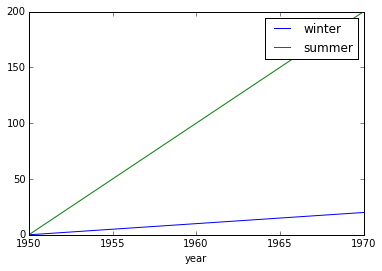

In [29]:
%pylab
%matplotlib inline
a = dataset['combined_data']
a.plot()

In addition, it can also display 2-D data via its methods `contour`, `contourf` and `pcolor` mapped from matplotlib.

/home/perrette/glacierenv/local/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


<matplotlib.contour.QuadContourSet instance at 0x7f729ce46b00>

/home/perrette/glacierenv/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


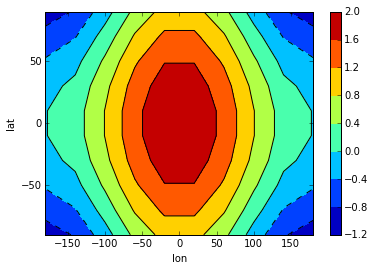

In [30]:
# create some data
lon = np.linspace(-180, 180, 10)
lat = np.linspace(-90, 90, 10)
LON, LAT = np.meshgrid(lon, lat)
DATA = np.cos(np.radians(LON)) + np.cos(np.radians(LAT))
# define dimarray
a = DimArray(DATA, axes=[lat, lon], dims=['lat','lon'])
# plot the data
c = a.contourf()
colorbar(c)  # explicit colorbar creation  # doctest: +SKIP
a.contour(colors='k') # doctest: +SKIP

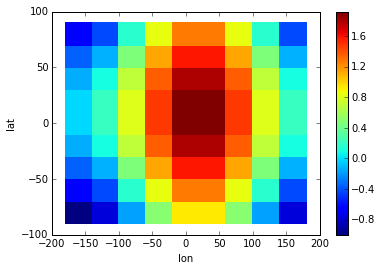

In [31]:
# plot the data
a.pcolor(colorbar=True)  # colorbar as keyword argument # doctest: +SKIP

For more information, you can use inline help (help() or ?) or refer to :ref:`page_reference` and :ref:`reference_api` 